## Seq2Seq Model

In this notebook, we finally construct our an encoder-decoder model for Grammatical Error Correction, modifying the hyperparameters, visualising the training and validation processes, and examining a selection of examples from the test data.

 The following notebook was developed based on the teaching unit at the University of Potsdam of Meng Li, which in turn was inspired by  [Ben Trevett's Seq2seq tutorial](https://github.com/bentrevett/pytorch-seq2seq/). 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
PATH = r"/content/gdrive/My Drive/Colab Notebooks/gec24"
os.chdir(PATH)

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import tqdm
import numpy as np
import sentencepiece as spm

Let's start by creating a function that will pad our sequences to the desired length.

In [7]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_src_ids = [example["src_ids"] for example in batch]
        batch_tgt_ids = [example["tgt_ids"] for example in batch]
        batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
        batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)
        batch = {
            "src_ids": batch_src_ids,
            "tgt_ids": batch_tgt_ids,
        }
        return batch

    return collate_fn

Next, we write the functions which give us our data loaders creating using PyTorch's DataLoader class.
get_data_loader is created using a Dataset, the batch size, the padding token index (which is used for creating the batches in the collate_fn, and a boolean deciding if the examples should be shuffled at the time the data loader is iterated over.
The batch size defines the maximum amount of examples within a batch. If the length of the dataset is not evenly divisible by the batch size then the last batch will be smaller.

In [8]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [9]:
model_name = 'unigram_16000'

Loading data:

In [10]:
train_data = torch.load("/content/gdrive/My Drive/Colab Notebooks/gec24/data/tokenized_data/unigram_16000_train.pt")
dev_data = torch.load("/content/gdrive/My Drive/Colab Notebooks/gec24/data/tokenized_data/unigram_16000_dev.pt")
test_data = torch.load("/content/gdrive/My Drive/Colab Notebooks/gec24/data/tokenized_data/unigram_16000_test.pt")

In [11]:
model_filename = 'tokenizer_models/' + model_name + '.model'
sp = spm.SentencePieceProcessor(model_file=model_filename)

Finally, we create our data loaders.

Shuffling of data makes training more stable and potentially improves the final performance of the model, however only needs to be done on the training set.

In [12]:
batch_size = 256
pad_index = 0

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
dev_data_loader = get_data_loader(dev_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

### Building  a model

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, tgt, teacher_forcing_ratio):
        # src = [src length, batch size]
        # tgt = [tgt length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = tgt.shape[1]
        tgt_length = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(tgt_length, batch_size, tgt_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = tgt[0, :]
        # input = [batch size]
        for t in range(1, tgt_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = tgt[t] if teacher_force else top1
            # input = [batch size]
        return outputs

Setting up the model

In [16]:
input_dim = sp.get_piece_size()
output_dim = sp.get_piece_size()
encoder_embedding_dim = 512
decoder_embedding_dim = 512
hidden_dim = 512
n_layers = 4
encoder_dropout = 0.5
decoder_dropout = 0.5
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(16000, 512)
    (rnn): LSTM(512, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(16000, 512)
    (rnn): LSTM(512, 512, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=16000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 41,401,984 trainable parameters


In [19]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [20]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [21]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["src_ids"].to(device)
        tgt = batch["tgt_ids"].to(device)
        # src = [src length, batch size]
        # tgt = [tgt length, batch size]
        optimizer.zero_grad()
        output = model(src, tgt, teacher_forcing_ratio)
        # output = [tgt length, batch size, tgt vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(tgt length - 1) * batch size, tgt vocab size]
        tgt = tgt[1:].view(-1)
        # tgt = [(tgt length - 1) * batch size]
        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [22]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["src_ids"].to(device)
            tgt = batch["tgt_ids"].to(device)
            # src = [src length, batch size]
            # tgt = [tgt length, batch size]
            output = model(src, tgt, 0)  # turn off teacher forcing
            # output = [tgt length, batch size, tgt vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(tgt length - 1) * batch size, tgt vocab size]
            tgt = tgt[1:].view(-1)
            # tgt = [(tgt length - 1) * batch size]
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [23]:
n_epochs = 30
clip = 1.0
teacher_forcing_ratio = 0.6
output_model = '/content/gdrive/My Drive/Colab Notebooks/gec24/models/model8.pt'

best_valid_loss = float("inf")
train_losses = []
valid_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        dev_data_loader,
        criterion,
        device,
    )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), output_model)
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  3%|▎         | 1/30 [03:13<1:33:28, 193.41s/it]

	Train Loss:   6.308 | Train PPL: 549.185
	Valid Loss:   6.119 | Valid PPL: 454.302


  7%|▋         | 2/30 [06:21<1:28:45, 190.19s/it]

	Train Loss:   6.094 | Train PPL: 443.145
	Valid Loss:   6.102 | Valid PPL: 446.772


 10%|█         | 3/30 [09:28<1:25:03, 189.02s/it]

	Train Loss:   6.030 | Train PPL: 415.517
	Valid Loss:   6.151 | Valid PPL: 469.368


 13%|█▎        | 4/30 [12:40<1:22:22, 190.09s/it]

	Train Loss:   5.826 | Train PPL: 338.840
	Valid Loss:   6.427 | Valid PPL: 618.577


 17%|█▋        | 5/30 [15:50<1:19:11, 190.06s/it]

	Train Loss:   5.701 | Train PPL: 299.302
	Valid Loss:   6.169 | Valid PPL: 477.494


 20%|██        | 6/30 [18:59<1:15:51, 189.66s/it]

	Train Loss:   5.546 | Train PPL: 256.319
	Valid Loss:   6.289 | Valid PPL: 538.399


 23%|██▎       | 7/30 [22:09<1:12:44, 189.78s/it]

	Train Loss:   5.403 | Train PPL: 222.109
	Valid Loss:   6.141 | Valid PPL: 464.704


 27%|██▋       | 8/30 [25:17<1:09:25, 189.33s/it]

	Train Loss:   5.305 | Train PPL: 201.403
	Valid Loss:   6.150 | Valid PPL: 468.698


 30%|███       | 9/30 [28:30<1:06:34, 190.23s/it]

	Train Loss:   5.203 | Train PPL: 181.792
	Valid Loss:   6.079 | Valid PPL: 436.742


 33%|███▎      | 10/30 [31:44<1:03:50, 191.53s/it]

	Train Loss:   5.158 | Train PPL: 173.792
	Valid Loss:   6.057 | Valid PPL: 427.045


 37%|███▋      | 11/30 [34:56<1:00:42, 191.73s/it]

	Train Loss:   5.076 | Train PPL: 160.097
	Valid Loss:   6.055 | Valid PPL: 426.358


 40%|████      | 12/30 [38:06<57:18, 191.02s/it]  

	Train Loss:   5.020 | Train PPL: 151.370
	Valid Loss:   6.021 | Valid PPL: 411.926


 43%|████▎     | 13/30 [41:20<54:25, 192.09s/it]

	Train Loss:   4.900 | Train PPL: 134.267
	Valid Loss:   5.857 | Valid PPL: 349.733


 47%|████▋     | 14/30 [44:34<51:23, 192.70s/it]

	Train Loss:   4.780 | Train PPL: 119.047
	Valid Loss:   5.778 | Valid PPL: 322.985


 50%|█████     | 15/30 [47:46<48:03, 192.25s/it]

	Train Loss:   4.681 | Train PPL: 107.829
	Valid Loss:   5.865 | Valid PPL: 352.409


 53%|█████▎    | 16/30 [50:57<44:49, 192.13s/it]

	Train Loss:   4.625 | Train PPL: 101.958
	Valid Loss:   5.733 | Valid PPL: 308.958


 57%|█████▋    | 17/30 [54:10<41:39, 192.28s/it]

	Train Loss:   4.545 | Train PPL:  94.173
	Valid Loss:   5.727 | Valid PPL: 306.996


 60%|██████    | 18/30 [57:22<38:27, 192.25s/it]

	Train Loss:   4.492 | Train PPL:  89.268
	Valid Loss:   5.722 | Valid PPL: 305.508


 63%|██████▎   | 19/30 [1:00:33<35:11, 191.93s/it]

	Train Loss:   4.446 | Train PPL:  85.258
	Valid Loss:   5.675 | Valid PPL: 291.595


 67%|██████▋   | 20/30 [1:03:43<31:51, 191.20s/it]

	Train Loss:   4.414 | Train PPL:  82.605
	Valid Loss:   5.649 | Valid PPL: 284.083


 70%|███████   | 21/30 [1:06:50<28:28, 189.85s/it]

	Train Loss:   4.331 | Train PPL:  76.012
	Valid Loss:   5.612 | Valid PPL: 273.781


 73%|███████▎  | 22/30 [1:10:01<25:21, 190.17s/it]

	Train Loss:   4.276 | Train PPL:  71.948
	Valid Loss:   5.550 | Valid PPL: 257.299


 77%|███████▋  | 23/30 [1:13:14<22:17, 191.07s/it]

	Train Loss:   4.222 | Train PPL:  68.201
	Valid Loss:   5.541 | Valid PPL: 254.897


 80%|████████  | 24/30 [1:16:26<19:08, 191.34s/it]

	Train Loss:   4.176 | Train PPL:  65.073
	Valid Loss:   5.491 | Valid PPL: 242.387


 83%|████████▎ | 25/30 [1:19:37<15:56, 191.36s/it]

	Train Loss:   4.125 | Train PPL:  61.843
	Valid Loss:   5.482 | Valid PPL: 240.304


 87%|████████▋ | 26/30 [1:22:43<12:38, 189.67s/it]

	Train Loss:   4.082 | Train PPL:  59.293
	Valid Loss:   5.502 | Valid PPL: 245.065


 90%|█████████ | 27/30 [1:25:54<09:30, 190.06s/it]

	Train Loss:   4.030 | Train PPL:  56.235
	Valid Loss:   5.480 | Valid PPL: 239.785


 93%|█████████▎| 28/30 [1:29:07<06:21, 190.87s/it]

	Train Loss:   4.002 | Train PPL:  54.700
	Valid Loss:   5.490 | Valid PPL: 242.363


 97%|█████████▋| 29/30 [1:32:16<03:10, 190.43s/it]

	Train Loss:   3.989 | Train PPL:  53.989
	Valid Loss:   5.428 | Valid PPL: 227.786


100%|██████████| 30/30 [1:35:27<00:00, 190.91s/it]

	Train Loss:   3.927 | Train PPL:  50.734
	Valid Loss:   5.437 | Valid PPL: 229.666


Visualizing the training:

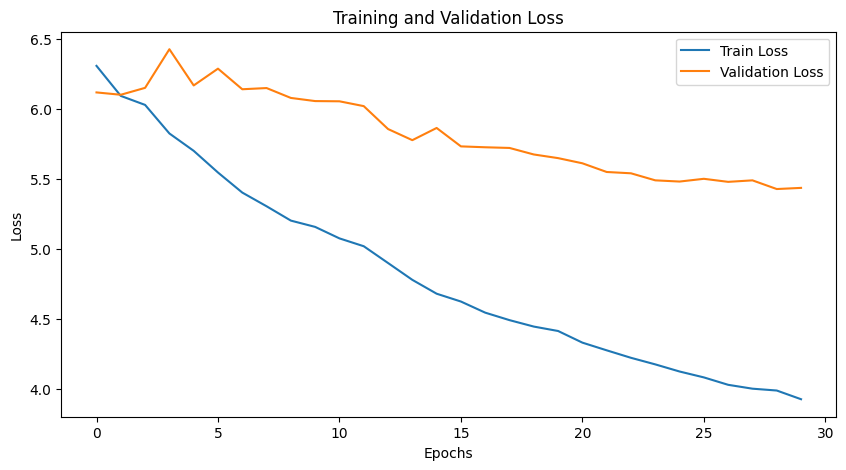

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Computing test loss:

In [25]:
model.load_state_dict(torch.load(output_model))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 6.152 | Test PPL: 469.835 |


At last, we can see how our model makes corrections to three sentences in practice.

In [26]:
def correct_sentence(
    sentence,
    model,
    sp,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        # Tokenize sentence with SentencePiece
        tokens = sp.encode_as_pieces(sentence)
        tokens = [sos_token] + tokens + [eos_token]  # Add SOS and EOS tokens

        # Encode tokens to get IDs
        ids = sp.encode_as_ids(sentence)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)

        hidden, cell = model.encoder(tensor)

        inputs = [sp.bos_id()]  # Use BOS token ID
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token_id = output.argmax(-1).item()
            inputs.append(predicted_token_id)
            if predicted_token_id == sp.eos_id():
                break

        # Decode predicted token IDs to tokens
        predicted_tokens = sp.decode_ids(inputs)

    return predicted_tokens

First example

In [27]:
sentence = test_data[17]["src"]
expected_correction = test_data[17]["tgt"]
sentence, expected_correction

("Although such a show of strength by these works ' characters is sometimes viewed as a violent and therefore negative contribution to the otherwise insightful thought of the author , it is this conflict upon which many stories of ethnic American literature are based .",
 "Although such a show of strength by these works ' characters is sometimes viewed as a violent and therefore negative contribution to the otherwise insightful thought of the author , it is this conflict upon which many stories of ethnic American literature are based .")

In [28]:
correction = correct_sentence(
    sentence,
    model,
    sp,
    'BOS',
    'EOS',
    'cuda'
)

In [29]:
correction

'In the beginning of the questionnaire , they of thess , thes , thes and thes and thes'

Second example

In [30]:
sentence = test_data[34]["src"]
expected_correction = test_data[34]["tgt"]
sentence, expected_correction

('On arrival they see starvation and death .',
 'On arrival they see starvation and death .')

In [31]:
correction = correct_sentence(
    sentence,
    model,
    sp,
    'BOS',
    'EOS',
    'cuda'
)
correction

'In addition , there are a lots .'

Third example

In [32]:
sentence = 'Two cats is catching a butterfly.'
correction = correct_sentence(
    sentence,
    model,
    sp,
    'BOS',
    'EOS',
    'cuda'
)
correction

'and verymental and , and a very .'